In [6]:
import pandas as pd
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

In [7]:
gas=pd.read_csv('gas_turbines (1).csv.crdownload')

## EDA

In [8]:
gas.shape

(12747, 11)

In [9]:
gas.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [10]:
gas.tail()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
12742,22.405,1013.2,90.999,3.1904,20.058,1059.0,550.06,111.23,10.549,2.1916,49.988
12743,22.350,1013.3,92.745,2.9947,18.440,1049.4,549.84,103.85,10.127,3.9442,48.855
12744,22.351,1013.4,93.447,2.9711,18.423,1049.3,549.98,103.77,10.026,4.2391,49.590
12745,22.987,1013.7,93.018,3.2344,20.206,1060.0,550.13,111.40,10.610,2.7860,50.672
12746,24.303,1013.9,88.424,3.2654,20.335,1060.7,549.98,111.57,10.643,2.5900,NaN


In [11]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12747 entries, 0 to 12746
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      12747 non-null  float64
 1   AP      12747 non-null  float64
 2   AH      12747 non-null  float64
 3   AFDP    12747 non-null  float64
 4   GTEP    12747 non-null  float64
 5   TIT     12747 non-null  float64
 6   TAT     12747 non-null  float64
 7   TEY     12747 non-null  float64
 8   CDP     12747 non-null  float64
 9   CO      12747 non-null  float64
 10  NOX     12746 non-null  float64
dtypes: float64(11)
memory usage: 1.1 MB


In [14]:
gas[gas.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

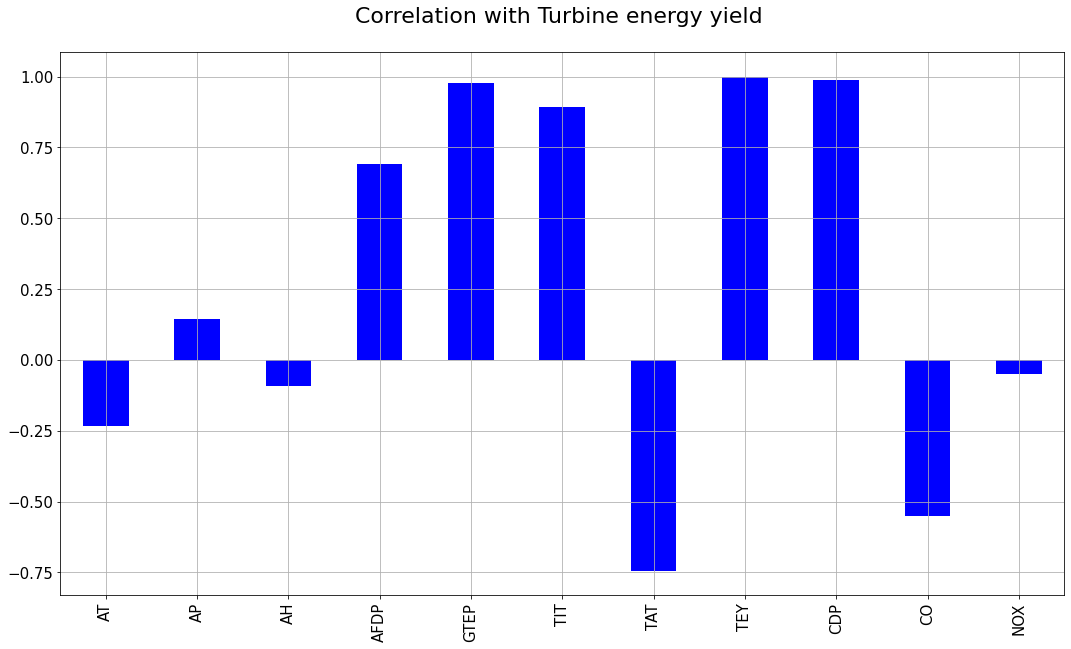

In [15]:
# correlation with TEY

data2 = gas.copy()

correlations = data2.corrwith(gas["TEY"])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'b',
        rot = 90, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

## Preprocessing

In [19]:
#Split the data into train and test
train_data=gas.sample(frac=0.8,random_state=0)
test_data=gas.drop(train_data.index)

In [20]:
# Look overall statistics
train_stats=train_data.describe()
train_stats.pop('TEY')
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
AT,10198.0,17.913486,7.738650,0.522300,11.353250,18.48950,24.136750,34.9290
AP,10198.0,1012.605228,6.103549,986.160000,1008.600000,1012.40000,1016.200000,1030.6000
AH,10198.0,79.155386,14.071567,30.344000,69.597500,82.70000,90.195000,100.2000
AFDP,10198.0,4.221822,0.785758,2.087400,3.729725,4.23235,4.562575,7.6106
GTEP,10198.0,25.488818,4.175936,18.028000,23.391500,25.15450,27.275000,37.4020
TIT,10198.0,1084.026250,16.250564,1024.600000,1081.300000,1088.80000,1096.200000,1100.6000
TAT,10198.0,545.455613,7.820903,513.060000,542.450000,549.89000,550.060000,550.5600
CDP,10198.0,12.109206,1.099437,9.904400,11.672000,12.03500,12.591250,15.0550
CO,10198.0,1.946486,2.177489,0.000388,0.819180,1.38530,2.167800,44.1030
NOX,10197.0,67.796149,10.176496,41.777000,61.074000,66.40900,73.128000,119.8900


In [21]:
# Split features from labels
train_labels=train_data.pop('TEY')
test_labels=test_data.pop('TEY')

In [22]:
# Normalize the data
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']
normed_train_data=norm(train_data)
normed_test_data=norm(test_data)


## Model Building

In [25]:
# Build the model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse','accuracy'])
    return model

In [26]:
model=build_model()

In [28]:
# Inspect the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [31]:
example_batch = normed_train_data[:10]
example_result= model.predict(example_batch)
example_result

1/1 [==============================] - 0s 16ms/step


array([[-0.30494457],
       [-0.11363931],
       [ 0.12786502],
       [-0.3646868 ],
       [-0.12012777],
       [ 0.09855555],
       [-0.46982026],
       [-0.2899565 ],
       [-0.15360776],
       [-0.35016975]], dtype=float32)

In [39]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
            print('.', end='')
EPOCHS=100
history = model.fit(
 normed_train_data,train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose = 0,
 callbacks=[PrintDot()])



.

In [40]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
95,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,95
96,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,96
97,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,97
98,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,98
99,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,99


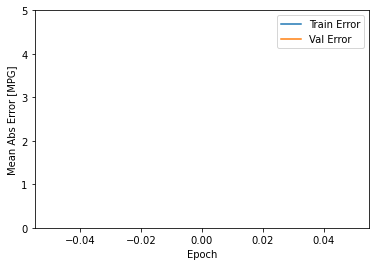

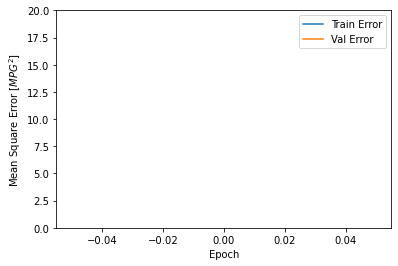

In [41]:
# Visualize the model's training progress
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,5])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'],hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,20])

plot_history(history)


.

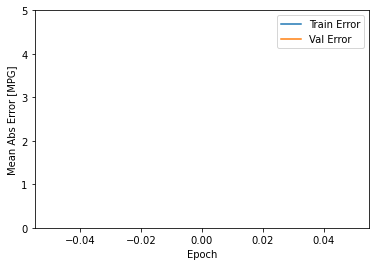

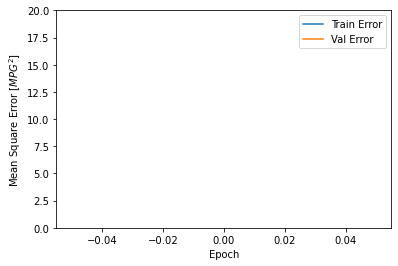

In [42]:
model = build_model()
# The patience parameter is the amount of epochs to check for improvement
early_stop= keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history=model.fit (normed_train_data,train_labels,epochs=EPOCHS,
                  validation_split = 0.2, verbose=0, callbacks=[early_stop,PrintDot()])
plot_history(history)

In [43]:
# let's see how well the model generalizes by using test set
d=model.evaluate(normed_test_data,test_labels,verbose=0)
print('Testing set Mean Abs Error: ',d[1]*100)

Testing set Mean Abs Error:  nan


## Predict

80/80 [==============================] - 0s 603us/step


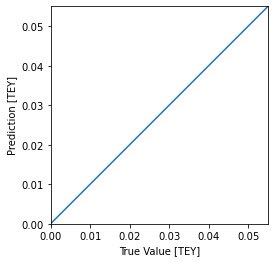

In [44]:
# fianlly, predict TEY values using data in the testing set:
test_prediction=model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_prediction)
plt.xlabel('True Value [TEY]')
plt.ylabel('Prediction [TEY]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_=plt.plot([-100,100],[-100,100])